In [1]:
from __future__ import division, print_function
import os, sys, warnings
import numpy as np
import matplotlib.pyplot as plt
from astropy.table import Table

In [2]:
params = {'legend.fontsize': 'x-large',
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large',
         'figure.facecolor':'w'} 
plt.rcParams.update(params)

In [21]:
cat_dir = '../downloads/'

# DECaLS catalog
decals = Table.read(cat_dir+'decals-dr7.1-UKBOSS_best_ukwide_v5_2-02jun2015-match.fits')
# matched best_ukwide catalog
mgc = Table.read(cat_dir+'UKBOSS_best_ukwide_v5_2-02jun2015-match.fits')

decals["DCHISQ_EXP"] = decals["DCHISQ"][:,3]
decals["DCHISQ_DEV"] = decals["DCHISQ"][:,2]
del decals["DCHISQ"]
decals = decals.to_pandas()

del mgc["ABSMAG_BEST"]
mgc = mgc.to_pandas()

In [20]:
decals[:3]

RELEASE,BRICKID,BRICKNAME,OBJID,TYPE,RA,DEC,RA_IVAR,DEC_IVAR,EBV,FLUX_U,FLUX_G,FLUX_R,FLUX_I,FLUX_Z,FLUX_Y,FLUX_W1,FLUX_W2,FLUX_W3,FLUX_W4,FLUX_IVAR_U,FLUX_IVAR_G,FLUX_IVAR_R,FLUX_IVAR_I,FLUX_IVAR_Z,FLUX_IVAR_Y,FLUX_IVAR_W1,FLUX_IVAR_W2,FLUX_IVAR_W3,FLUX_IVAR_W4,MW_TRANSMISSION_U,MW_TRANSMISSION_G,MW_TRANSMISSION_R,MW_TRANSMISSION_I,MW_TRANSMISSION_Z,MW_TRANSMISSION_Y,MW_TRANSMISSION_W1,MW_TRANSMISSION_W2,MW_TRANSMISSION_W3,MW_TRANSMISSION_W4,NOBS_U,NOBS_G,NOBS_R,NOBS_I,NOBS_Z,NOBS_Y,NOBS_W1,NOBS_W2,NOBS_W3,NOBS_W4,RCHISQ_U,RCHISQ_G,RCHISQ_R,RCHISQ_I,RCHISQ_Z,RCHISQ_Y,RCHISQ_W1,RCHISQ_W2,RCHISQ_W3,RCHISQ_W4,FRACFLUX_U,FRACFLUX_G,FRACFLUX_R,FRACFLUX_I,FRACFLUX_Z,FRACFLUX_Y,FRACFLUX_W1,FRACFLUX_W2,FRACFLUX_W3,FRACFLUX_W4,FRACMASKED_U,FRACMASKED_G,FRACMASKED_R,FRACMASKED_I,FRACMASKED_Z,FRACMASKED_Y,FRACIN_U,FRACIN_G,FRACIN_R,FRACIN_I,FRACIN_Z,FRACIN_Y,ANYMASK_U,ANYMASK_G,ANYMASK_R,ANYMASK_I,ANYMASK_Z,ANYMASK_Y,ALLMASK_U,ALLMASK_G,ALLMASK_R,ALLMASK_I,ALLMASK_Z,ALLMASK_Y,WISEMASK_W1,WISEMASK_W2,PSFSIZE_U,PSFSIZE_G,PSFSIZE_R,PSFSIZE_I,PSFSIZE_Z,PSFSIZE_Y,PSFDEPTH_U,PSFDEPTH_G,PSFDEPTH_R,PSFDEPTH_I,PSFDEPTH_Z,PSFDEPTH_Y,GALDEPTH_U,GALDEPTH_G,GALDEPTH_R,GALDEPTH_I,GALDEPTH_Z,GALDEPTH_Y,WISE_COADD_ID,FRACDEV,FRACDEV_IVAR,SHAPEDEV_R,SHAPEDEV_R_IVAR,SHAPEDEV_E1,SHAPEDEV_E1_IVAR,SHAPEDEV_E2,SHAPEDEV_E2_IVAR,SHAPEEXP_R,SHAPEEXP_R_IVAR,SHAPEEXP_E1,SHAPEEXP_E1_IVAR,SHAPEEXP_E2,SHAPEEXP_E2_IVAR,FIBERFLUX_U,FIBERFLUX_G,FIBERFLUX_R,FIBERFLUX_I,FIBERFLUX_Z,FIBERFLUX_Y,FIBERTOTFLUX_U,FIBERTOTFLUX_G,FIBERTOTFLUX_R,FIBERTOTFLUX_I,FIBERTOTFLUX_Z,FIBERTOTFLUX_Y,REF_ID,GAIA_PHOT_G_MEAN_MAG,GAIA_PHOT_G_MEAN_FLUX_OVER_ERROR,GAIA_PHOT_BP_MEAN_MAG,GAIA_PHOT_BP_MEAN_FLUX_OVER_ERROR,GAIA_PHOT_RP_MEAN_MAG,GAIA_PHOT_RP_MEAN_FLUX_OVER_ERROR,GAIA_ASTROMETRIC_EXCESS_NOISE,GAIA_DUPLICATED_SOURCE,PARALLAX,PARALLAX_IVAR,PMRA,PMRA_IVAR,PMDEC,PMDEC_IVAR,BRIGHTSTARINBLOB,radius,DCHISQ_EXP,DCHISQ_DEV
int32,int32,bytes8,int32,bytes4,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int16,int16,int16,int16,int16,int16,int16,int16,int16,int16,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int16,int16,int16,int16,int16,int16,int16,int16,int16,int16,int16,int16,uint8,uint8,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,bytes8,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int64,float32,float32,float32,float32,float32,float32,float32,bool,float32,float32,float32,float32,float32,float32,bool,float64,float32,float32
7000,324436,3171m012,5791,DEV,317.2348013896928,-1.1859251955099737,945248000000.0,847177400000.0,0.070424676,0.0,1.6334922,8.638808,0.0,21.223198,0.0,37.137375,27.825829,148.09274,326.55957,0.0,935.0122,345.3667,0.0,55.48329,0.0,2.4047616,0.4575722,0.0007392743,1.6403083e-05,0.77172285,0.81182426,0.8689849,0.90189,0.9244561,0.9333129,0.98813605,0.99269724,0.998438,0.9994099,0,5,4,0,5,0,124,119,11,11,0.0,1.6799982,2.166657,0.0,1.4476653,0.0,3.4947941,0.65500337,0.4630503,0.076106176,0.0,0.9090946,0.08723171,0.0,0.03921906,0.0,0.4025441,0.33162597,0.5440063,2.296249,0.0,0.05250681,0.013257954,0.0,0.014774677,0.0,0.0,0.76961917,0.9992767,0.0,0.9999722,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,1.4640014,1.194505,0.0,1.19784,0.0,0.0,2783.7744,1538.7067,0.0,209.0545,0.0,0.0,1701.6418,813.94885,0.0,107.71192,0.0,3176m016,1.0,1.0,0.80259275,18279.348,0.08019593,9793.119,-0.15831986,14610.598,0.

In [5]:
mgc[:3]

OBJID,RA,DEC,ORIGIN_BEST,ZBEST,ZPERT,MASS_IR_BEST,MASSERR_IR_BEST,MASS_IR_PERT,MASS_OPT_BEST,MASSERR_OPT_BEST,MASS_OPT_PERT,B1000_IR_BEST,B300_IR_BEST,KCOR_MASS_BEST,ABSMAG_BEST [9],SIGMAZ_REIS,SIGMAZ_RM,SIGMAZ_ZRED,SIGMAZ_BEST,LUMERR_DEX
int64,float64,float64,int16,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32
8647474690315780209,317.234823792424,-1.18593054181581,2,0.41665068,0.36470288,11.013946,0.06197214,10.913042,10.988556,0.08948898,10.900223,0.003077125,6.536538e-10,10.652373,-17.738686 .. -22.09507,0.03322047,-1.0,0.022846403,0.022846403,0.026534965
8647474690315780138,317.217689546912,-1.16379182672661,1,0.552395,0.5544369,11.09685,0.06615257,11.077892,11.168348,0.085894585,11.208653,0.061571013,0.010593866,10.733143,-19.994884 .. -22.558405,0.038194403,-1.0,-1.0,0.038194403,0.028936625
8647474690315780139,317.217361698708,-1.16162833003431,1,0.642978,0.6311344,11.18847,0.083909035,11.315879,10.820254,0.09964037,10.813088,0.35958308,1.0791874e-09,10.577702,-19.225876 .. -22.884487,0.053482655,-1.0,-1.0,0.053482655,0.051568896


In [6]:
# Apply extinction correction for DECaLS
decals['FLUX_G'] = decals['FLUX_G']/decals['MW_TRANSMISSION_G']
decals['FLUX_R'] = decals['FLUX_R']/decals['MW_TRANSMISSION_R']
decals['FLUX_Z'] = decals['FLUX_Z']/decals['MW_TRANSMISSION_Z']
decals['FLUX_W1'] = decals['FLUX_W1']/decals['MW_TRANSMISSION_W1']
decals['FLUX_W2'] = decals['FLUX_W2']/decals['MW_TRANSMISSION_W2']

# Compute extinction-corrected magnitudes and errors for DECaLS
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    decals['gmag'] = 22.5 - 2.5*np.log10(decals['FLUX_G'])
    decals['rmag'] = 22.5 - 2.5*np.log10(decals['FLUX_R'])
    decals['zmag'] = 22.5 - 2.5*np.log10(decals['FLUX_Z'])
    decals['w1mag'] = 22.5 - 2.5*np.log10(decals['FLUX_W1'])
    decals['w2mag'] = 22.5 - 2.5*np.log10(decals['FLUX_W2'])
    decals['gmagerr'] = 1/np.sqrt(decals['FLUX_IVAR_G'])/decals['FLUX_G']
    decals['rmagerr'] = 1/np.sqrt(decals['FLUX_IVAR_R'])/decals['FLUX_R']
    decals['zmagerr'] = 1/np.sqrt(decals['FLUX_IVAR_Z'])/decals['FLUX_Z']
    decals['w1magerr'] = 1/np.sqrt(decals['FLUX_IVAR_W1'])/decals['FLUX_W1']
    decals['w2magerr'] = 1/np.sqrt(decals['FLUX_IVAR_W2'])/decals['FLUX_W2']
    
# Restrict to DECaLS objects with 2+ exposures in grz bands
mask = (decals['NOBS_G']>=2) & (decals['NOBS_R']>=2) & (decals['NOBS_Z']>=2)
print(np.sum(~mask)/len(mask))
decals = decals[mask]
mgc = mgc[mask]

# Require valid grzW1W2 photometry
mask = np.isfinite(decals['gmag']) & np.isfinite(decals['rmag']) & np.isfinite(decals['zmag']) & \
        np.isfinite(decals['w1mag']) & np.isfinite(decals['w2mag'])
print(np.sum(~mask)/len(mask))
decals = decals[mask]
mgc = mgc[mask]

0.006582100458056051
0.00738496946161892


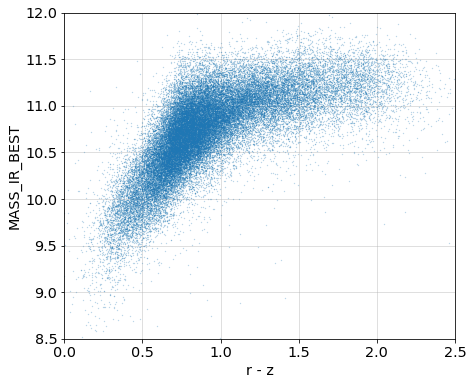

In [8]:
# Stellar mass vs r-z color
plt.figure(figsize=(7, 6))
plt.plot((decals['rmag']-decals['zmag'])[::10], (mgc['MASS_IR_BEST'])[::10], '.', markersize=0.5, alpha=0.5)
plt.xlabel('r - z')
plt.ylabel('MASS_IR_BEST')
plt.grid(alpha=0.5)
plt.axis([0, 2.5, 8.5, 12])
plt.show()

__Some derived morphological parameters:__

In [9]:
# ratio between semi-minor axis and semi-major axis
# See http://legacysurvey.org/dr7/catalogs/#ellipticities
e = np.zeros(len(decals)) # the e parameter is zero for circularly symmetric profiles (PSF and SIMP)
mask = (decals['TYPE']=='EXP') | (decals['TYPE']=='EXP ')
e[mask] = (np.sqrt(decals['SHAPEEXP_E1']**2+decals['SHAPEEXP_E2']**2))[mask]
mask = (decals['TYPE']=='DEV') | (decals['TYPE']=='DEV ')
e[mask] = (np.sqrt(decals['SHAPEDEV_E1']**2+decals['SHAPEDEV_E2']**2))[mask]
mask = (decals['TYPE']=='COMP')
e[mask] = ((1-decals['FRACDEV']) * np.sqrt(decals['SHAPEEXP_E1']**2+decals['SHAPEEXP_E2']**2) \
          + decals['FRACDEV'] * np.sqrt(decals['SHAPEDEV_E1']**2+decals['SHAPEDEV_E2']**2))[mask]
q = (1-e)/(1+e)

# shape probability (definition of shape probability in Soo et al. 2017)
# this parameter characterizes how well an object is fit by exponential profile vs de Vaucouleurs profile
p = np.ones(len(decals))*0.5
# DCHISQ[:, 2] is DCHISQ_EXP; DCHISQ[:, 3] is DCHISQ_DEV
mask_chisq = (decals['DCHISQ'][:, 3]>0) & (decals['DCHISQ'][:, 2]>0)
p[mask_chisq] = decals['DCHISQ'][:, 3][mask_chisq]/(decals['DCHISQ'][:, 3]+decals['DCHISQ'][:, 2])[mask_chisq]

decals['q'] = q
decals['p'] = p